# Import libraries

In [1]:
import pandas as pd 
from sklearn.model_selection import KFold
import keras
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from sklearn.preprocessing import LabelEncoder 
from keras.utils import np_utils
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings

# Import the data

In [2]:
! mkdir ~/.kaggle #create local kaggle folder
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/ #move auth key from one drive to temp folder
! chmod 600 ~/.kaggle/kaggle.json #use auth key
! kaggle datasets download rtatman/chocolate-bar-ratings -f flavors_of_cacao.csv #download the file from kaggle and unzip it while it is downloading

mkdir: cannot create directory ‘/root/.kaggle’: File exists
flavors_of_cacao.csv: Skipping, found more recently modified local copy (use --force to force download)


# Save data to pandas

In [3]:
cacao_dataframe_full=pd.read_csv('/content/flavors_of_cacao.csv')

In [4]:
cacao_dataframe_full

,Company \n(Maker-if known),Specific Bean Origin\nor Bar Name,REF,Review\nDate,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru
...,...,...,...,...,...,...,...,...,...
1790,Zotter,Peru,647,2011,70%,Austria,3.75,,Peru
1791,Zotter,Congo,749,2011,65%,Austria,3.00,Forastero,Congo
1792,Zotter,Kerala State,749,2011,65%,Austria,3.50,Forastero,India
1793,Zotter,Kerala State,781,2011,62%,Austria,3.25,,India


# Filter the data

In [5]:
cacao_dataframe = cacao_dataframe_full

In [6]:
del cacao_dataframe["Company\xa0\n(Maker-if known)"]

In [7]:
del cacao_dataframe["REF"]

In [8]:
del cacao_dataframe["Review\nDate"]

In [9]:
cacao_dataframe

,Specific Bean Origin\nor Bar Name,Cocoa\nPercent,Company\nLocation,Rating,Bean\nType,Broad Bean\nOrigin
0,Agua Grande,63%,France,3.75,,Sao Tome
1,Kpime,70%,France,2.75,,Togo
2,Atsane,70%,France,3.00,,Togo
3,Akata,70%,France,3.50,,Togo
4,Quilla,70%,France,3.50,,Peru
...,...,...,...,...,...,...
1790,Peru,70%,Austria,3.75,,Peru
1791,Congo,65%,Austria,3.00,Forastero,Congo
1792,Kerala State,65%,Austria,3.50,Forastero,India
1793,Kerala State,62%,Austria,3.25,,India


In [10]:
cacao_dataframe.columns = cacao_dataframe.columns.str.replace("\n", ' ', regex=True)

In [11]:
cacao_dataframe2 = pd.DataFrame(cacao_dataframe["Cocoa Percent"].str.replace("%",""))
cacao_dataframe.drop(["Cocoa Percent"], axis=1, inplace=True)
cacao_dataframe = cacao_dataframe.join(cacao_dataframe2)

In [12]:
cacao_dataframe

,Specific Bean Origin or Bar Name,Company Location,Rating,Bean Type,Broad Bean Origin,Cocoa Percent
0,Agua Grande,France,3.75,,Sao Tome,63
1,Kpime,France,2.75,,Togo,70
2,Atsane,France,3.00,,Togo,70
3,Akata,France,3.50,,Togo,70
4,Quilla,France,3.50,,Peru,70
...,...,...,...,...,...,...
1790,Peru,Austria,3.75,,Peru,70
1791,Congo,Austria,3.00,Forastero,Congo,65
1792,Kerala State,Austria,3.50,Forastero,India,65
1793,Kerala State,Austria,3.25,,India,62


In [13]:
cacao_dataframe_full = cacao_dataframe_full.loc[cacao_dataframe_full.index.repeat(10)]
cacao_dataframe_full = cacao_dataframe_full.reset_index(drop=True)

In [14]:
# Target is to place them into five categories 
def fix_ratings(rating):
    if rating < 0.5: 
        return 0.0 
    elif rating < 1.5: 
        return 1.0 
    elif rating < 2.5: 
        return 2.0
    elif rating < 3.5: 
        return 3.0
    elif rating < 4.5: 
        return 4.0 
    elif rating < 5.5: 
        return 5.0
  
cacao_dataframe_full["Rating"] = cacao_dataframe_full["Rating"].apply(lambda x: fix_ratings(x))

# One hot encoding of the data

In [15]:
encoded_dataframe = pd.DataFrame()
encoder = OneHotEncoder(handle_unknown='ignore')
def encodeRow(df, columnName):
    encoder_df = pd.DataFrame(encoder.fit_transform(df[columnName]).toarray())
    newNames= []
    for x in encoder.get_feature_names_out():
       x = x.replace("_", " ")
       x = x.rstrip()
       x = x.replace('\n', "_")
       x = x.replace(' ', "_")
       newNames.append(x)
    encoder_df.columns = list(newNames)
    return encoder_df

encoded_dataframe = cacao_dataframe_full.join(encodeRow(cacao_dataframe_full,["Specific Bean Origin or Bar Name","Company Location", "Bean Type", "Broad Bean Origin"]))
encoded_dataframe.drop(["Specific Bean Origin or Bar Name","Company Location", "Bean Type", "Broad Bean Origin"], axis=1, inplace=True)

encoded_dataframe

,Rating,"Specific_Bean_Origin_or_Bar_Name_""heirloom"",_Arriba_Nacional",Specific_Bean_Origin_or_Bar_Name_100_percent,Specific_Bean_Origin_or_Bar_Name_2009_Hapa_Nibby,"Specific_Bean_Origin_or_Bar_Name_A_case_of_the_Xerces_Blues,_triple_roast",Specific_Bean_Origin_or_Bar_Name_ABOCFA_Coop,Specific_Bean_Origin_or_Bar_Name_Abinao,"Specific_Bean_Origin_or_Bar_Name_Abstract_S._w/_Jamaica_nibs,batch_abs60323.0","Specific_Bean_Origin_or_Bar_Name_Acarigua,_w/_nibs",Specific_Bean_Origin_or_Bar_Name_Acopagro,...,"Broad_Bean_Origin_Venezuela,_Carribean","Broad_Bean_Origin_Venezuela,_Dom._Rep.","Broad_Bean_Origin_Venezuela,_Ghana","Broad_Bean_Origin_Venezuela,_Java","Broad_Bean_Origin_Venezuela,_Trinidad",Broad_Bean_Origin_Venezuela/_Ghana,Broad_Bean_Origin_Vietnam,Broad_Bean_Origin_West_Africa,Broad_Bean_Origin,Broad_Bean_Origin_nan
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17945,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17946,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17947,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17948,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Split the data - X, y

In [16]:
encoded_dataframe

,Rating,"Specific_Bean_Origin_or_Bar_Name_""heirloom"",_Arriba_Nacional",Specific_Bean_Origin_or_Bar_Name_100_percent,Specific_Bean_Origin_or_Bar_Name_2009_Hapa_Nibby,"Specific_Bean_Origin_or_Bar_Name_A_case_of_the_Xerces_Blues,_triple_roast",Specific_Bean_Origin_or_Bar_Name_ABOCFA_Coop,Specific_Bean_Origin_or_Bar_Name_Abinao,"Specific_Bean_Origin_or_Bar_Name_Abstract_S._w/_Jamaica_nibs,batch_abs60323.0","Specific_Bean_Origin_or_Bar_Name_Acarigua,_w/_nibs",Specific_Bean_Origin_or_Bar_Name_Acopagro,...,"Broad_Bean_Origin_Venezuela,_Carribean","Broad_Bean_Origin_Venezuela,_Dom._Rep.","Broad_Bean_Origin_Venezuela,_Ghana","Broad_Bean_Origin_Venezuela,_Java","Broad_Bean_Origin_Venezuela,_Trinidad",Broad_Bean_Origin_Venezuela/_Ghana,Broad_Bean_Origin_Vietnam,Broad_Bean_Origin_West_Africa,Broad_Bean_Origin,Broad_Bean_Origin_nan
0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17945,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17946,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17947,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17948,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X = encoded_dataframe.iloc[:,1:len(encoded_dataframe.columns)]
y = encoded_dataframe.iloc[:,0:1]

# Split the data - k-fold

In [18]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 6)
def kFoldValidation(df):
  result = next(kf.split(df), None)
  train = df.iloc[result[0]]
  test =  df.iloc[result[1]]
  return train, test

In [19]:
X_train, X_val_and_test = kFoldValidation(X)
y_train, y_val_and_test = kFoldValidation(y)
X_val, X_test = kFoldValidation(X_val_and_test)
y_val, y_test = kFoldValidation(y_val_and_test)

In [20]:
sc = StandardScaler(with_mean=False)
sc.fit(X_train)

le = LabelEncoder()
le.fit(y_train)

X_train_transf = sc.transform(X_train)
X_test_transf = sc.transform(X_test)
X_val_transf = sc.transform(X_val)

y_train_cat = np_utils.to_categorical(le.transform(y_train))
y_test_cat = np_utils.to_categorical(le.transform(y_test))
y_val_cat = np_utils.to_categorical(le.transform(y_val))

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Build NN

In [21]:
model = models.Sequential()
# hidden layer 1
model.add(layers.Dense(250, 
                       activation='LeakyReLU', 
                       input_dim=X_train.shape[1], 
                       kernel_regularizer=regularizers.l2(0.00001)))
model.add(layers.Dropout(0.3))
# hidden layer 2
model.add(layers.Dense(100, activation='LeakyReLU'))
model.add(layers.Dropout(0.2))
# hidden layer 3
model.add(layers.Dense(50, activation='LeakyReLU'))
model.add(layers.Dropout(0.2))
# output layer, 5 untis since ratings are 1,2,3,4,5
model.add(layers.Dense(5, activation='softplus'))

In [22]:
model.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history = model.fit(X_train_transf, 
                    y_train_cat, 
                    validation_data=(X_val_transf, y_val_cat),
                    batch_size=158, 
                    epochs=100, 
                    verbose=2)

Epoch 1/100
103/103 - 4s - loss: 0.6001 - accuracy: 0.7465 - val_loss: 0.3232 - val_accuracy: 0.8440 - 4s/epoch - 41ms/step
Epoch 2/100
103/103 - 2s - loss: 0.3094 - accuracy: 0.8538 - val_loss: 0.2812 - val_accuracy: 0.8440 - 2s/epoch - 21ms/step
Epoch 3/100
103/103 - 2s - loss: 0.2728 - accuracy: 0.8637 - val_loss: 0.2541 - val_accuracy: 0.8613 - 2s/epoch - 23ms/step
Epoch 4/100
103/103 - 2s - loss: 0.2587 - accuracy: 0.8701 - val_loss: 0.2448 - val_accuracy: 0.8663 - 2s/epoch - 23ms/step
Epoch 5/100
103/103 - 2s - loss: 0.2420 - accuracy: 0.8771 - val_loss: 0.2356 - val_accuracy: 0.8706 - 2s/epoch - 24ms/step
Epoch 6/100
103/103 - 3s - loss: 0.2361 - accuracy: 0.8790 - val_loss: 0.2311 - val_accuracy: 0.8731 - 3s/epoch - 27ms/step
Epoch 7/100
103/103 - 2s - loss: 0.2299 - accuracy: 0.8816 - val_loss: 0.2320 - val_accuracy: 0.8712 - 2s/epoch - 24ms/step
Epoch 8/100
103/103 - 2s - loss: 0.2252 - accuracy: 0.8837 - val_loss: 0.2195 - val_accuracy: 0.8817 - 2s/epoch - 21ms/step
Epoch 9/

# Test NN

In [24]:
scores = model.evaluate(X_test_transf, y_test_cat, batch_size=128)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

2/2 [==============================] - 0s 8ms/step - loss: 0.1397 - accuracy: 0.9278
accuracy: 92.78%


# Calculate and display model results

In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
training_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

training_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

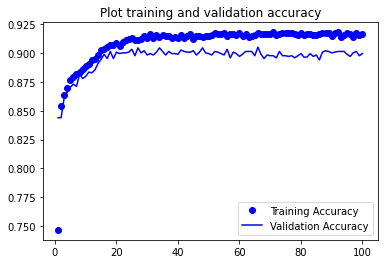

In [27]:
epochs = range(1, len(val_acc) + 1)

plt.plot(epochs, training_acc, 'bo', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')

plt.title('Plot training and validation accuracy')

plt.legend()
plt.show()

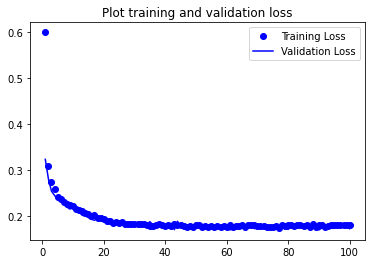

In [28]:
epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')

plt.title('Plot training and validation loss')

plt.legend()
plt.show()

#Confusion Matrix

In [29]:
warnings.filterwarnings('ignore')
preds = model.predict(X_test_transf)
preds = np.where(preds < 0.5, 0, 1)

target_names = ['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']
cm = multilabel_confusion_matrix(y_test_cat, preds)
print(classification_report(y_test_cat, preds, target_names=target_names))

              precision    recall  f1-score   support

    Rating 1       0.00      0.00      0.00         0
    Rating 2       0.33      0.80      0.47         5
    Rating 3       0.86      0.78      0.82       104
    Rating 4       0.67      0.78      0.72        69
    Rating 5       0.67      1.00      0.80         2

   micro avg       0.74      0.78      0.76       180
   macro avg       0.51      0.67      0.56       180
weighted avg       0.77      0.78      0.77       180
 samples avg       0.66      0.78      0.70       180



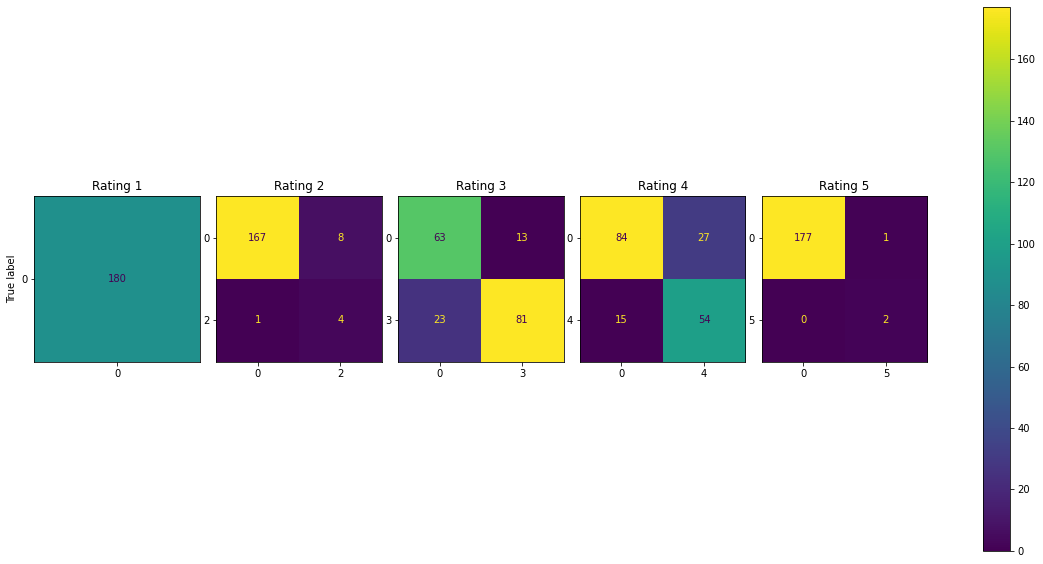

In [30]:
f, axes = plt.subplots(1, 5, figsize=(20, 10))
axes = axes.ravel()
for i in range(5):
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test_cat[:, i],
                                                   preds[:, i]),
                                  display_labels=[0, i+1])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'Rating {i+1}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()